This is a quick and dirty summary of the compiled datasets

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime 

sns.set()

In [2]:
# set color palettes for plotting
isr_col = sns.color_palette()[0]
pal_col = sns.color_palette()[3]
both_col = sns.color_palette()[4]
palette = [pal_col, isr_col]

In [3]:
def filter_df_by_date(df, date_range):
    df = df[df['date'] >= date_range[0]]
    df = df[df['date'] <= date_range[1]]
    
    return df.reset_index(drop=True)

In [4]:
# load data
globe = pd.read_csv('data/globe_sentences.csv', index_col=0)
star = pd.read_csv('data/star_sentences.csv', index_col=0)
post = pd.read_csv('data/post_sentences.csv', index_col=0)

# filter by date_range (inclusive)
date_range = ['2023-10-07', '2023-11-24']
globe = filter_df_by_date(globe, date_range)
star = filter_df_by_date(star, date_range)
post = filter_df_by_date(post, date_range)

In [5]:
# ocha data
ocha = pd.read_csv('data/ocha.csv')
ocha = filter_df_by_date(ocha, date_range)

PAL_DEATHS_NOV_24 = 15013
ISR_DEATHS_NOV_24 = 1279

In [6]:
def count_death_mentions(df, publication_name, date_range, pal_ocha=PAL_DEATHS_NOV_24, isr_ocha=ISR_DEATHS_NOV_24):
    article_count = len(df['url'].unique())
    print(f'{publication_name}: {date_range[0]} to {date_range[1]} ({article_count} articles)')
    print('----'*10)
    
    # get total mentions of death
    isr_deaths = df[df['victim'].isin(['Israeli', 'Both'])].copy()
    pal_deaths = df[df['victim'].isin(['Palestinian', 'Both'])].copy()
    print(f'\n{len(isr_deaths)} mentions of Israeli deaths')
    print(f'{len(pal_deaths)} mentions of Palestinian deaths')

    # deaths per mention
    isr_ratio = isr_ocha / len(isr_deaths)
    pal_ratio = pal_ocha / len(pal_deaths)
    print(f'\n{isr_ratio:.2f} Israeli deaths per mention')
    print(f'{pal_ratio:.2f} Palestinian deaths per mention')

    # get total mentions of blame
    isr_blame = df[df['responsible'].isin(['Israel', 'Both'])].copy()
    hamas_blame = df[df['responsible'].isin(['Hamas', 'Both'])].copy()
    print(f'\n{len(isr_blame)} mentions of Israeli responsibility')
    print(f'{len(hamas_blame)} mentions of Hamas responsibility')

    # deaths per blame
    isr_blame_ratio = pal_ocha / len(isr_blame)
    hamas_blame_ratio = isr_ocha / len(hamas_blame)
    print(f'\n{hamas_blame_ratio:.2f} Israeli deaths per mention of Hamas responsibility')
    print(f'{isr_blame_ratio:.2f} Palestinian deaths per mention of Israel responsibility')

    # proportion of death mentions blamed
    hamas_blame_proportion = len(hamas_blame) / len(isr_deaths)
    isr_blame_proportion = len(isr_blame) / len(pal_deaths)
    print(f'\n{hamas_blame_proportion:.2%} of Israeli death mentions blamed on Hamas')
    print(f'{isr_blame_proportion:.2%} of Palestinian death mentions blamed on Israel')

    return pal_deaths, isr_deaths

In [8]:
def plot_death_mentions(df, publication_name, date_range, palette, figsize=(12,3), **kwargs):
    # get total mentions of death
    isr_deaths = df[df['victim'].isin(['Israeli', 'Both'])].copy()
    pal_deaths = df[df['victim'].isin(['Palestinian', 'Both'])].copy()

    # daily counts
    pal_dates = pd.to_datetime(pal_deaths['date'])
    pal_dates = pal_dates.dt.floor('d')
    pal_counts = pd.DataFrame(pal_dates.value_counts(sort=False))
    pal_counts.rename(columns={'count': 'palestinian'}, inplace=True)

    isr_dates = pd.to_datetime(isr_deaths['date'])
    isr_dates = isr_dates.dt.floor('d')
    isr_counts = pd.DataFrame(isr_dates.value_counts(sort=False))
    isr_counts.rename(columns={'count': 'israeli'}, inplace=True)

    # combine for plotting
    daily_mentions = pal_counts.join(isr_counts, how='left').fillna(0).astype('int')

    # plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(daily_mentions, ax=ax, palette=palette, dashes=False, **kwargs)

    ax.set_title(f'{publication_name}: Published references to fatalities ({date_range[0]} to {date_range[1]})')
    ax.set_ylabel('# daily mentions')
    ax.set_xlabel('publication date')
    ax.set_xticks(daily_mentions.index[::7])
    ax.set_xticklabels(daily_mentions.index[::7].strftime('%b %d'))
    fig.autofmt_xdate(rotation=45)
    plt.show()

    return fig, ax

In [9]:
def plot_blame_mentions(df, publication_name, date_range, palette, figsize=(12,3), **kwargs):
    # get total mentions of death
    isr_blame = df[df['responsible'].isin(['Israel', 'Both'])].copy()
    hamas_blame = df[df['responsible'].isin(['Hamas', 'Both'])].copy()

    # daily counts
    hamas_dates = pd.to_datetime(hamas_blame['date'])
    hamas_dates = hamas_dates.dt.floor('d')
    hamas_counts = pd.DataFrame(hamas_dates.value_counts(sort=False)) #.reset_index()
    hamas_counts.rename(columns={'count': 'hamas'}, inplace=True)

    isr_dates = pd.to_datetime(isr_blame['date'])
    isr_dates = isr_dates.dt.floor('d')
    isr_counts = pd.DataFrame(isr_dates.value_counts(sort=False)) #.reset_index()
    isr_counts.rename(columns={'count': 'israel'}, inplace=True)

    # combine for plotting
    daily_mentions = hamas_counts.join(isr_counts, how='left').fillna(0).astype('int')

    # plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(daily_mentions, ax=ax, palette=palette, dashes=False, **kwargs)

    ax.set_title(f'{publication_name}: Published references to group responsible ({date_range[0]} to {date_range[1]})')
    ax.set_ylabel('# daily mentions')
    ax.set_xlabel('publication date')
    ax.set_xticks(daily_mentions.index[::7])
    ax.set_xticklabels(daily_mentions.index[::7].strftime('%b %d'))
    fig.autofmt_xdate(rotation=45)
    plt.show()

    return fig, ax 

The Globe and Mail: 2023-10-07 to 2023-11-24 (282 articles)
----------------------------------------

531 mentions of Israeli deaths
764 mentions of Palestinian deaths

2.41 Israeli deaths per mention
19.65 Palestinian deaths per mention

334 mentions of Israeli responsibility
397 mentions of Hamas responsibility

3.22 Israeli deaths per mention of Hamas responsibility
44.95 Palestinian deaths per mention of Israel responsibility

74.76% of Israeli death mentions blamed on Hamas
43.72% of Palestinian death mentions blamed on Israel


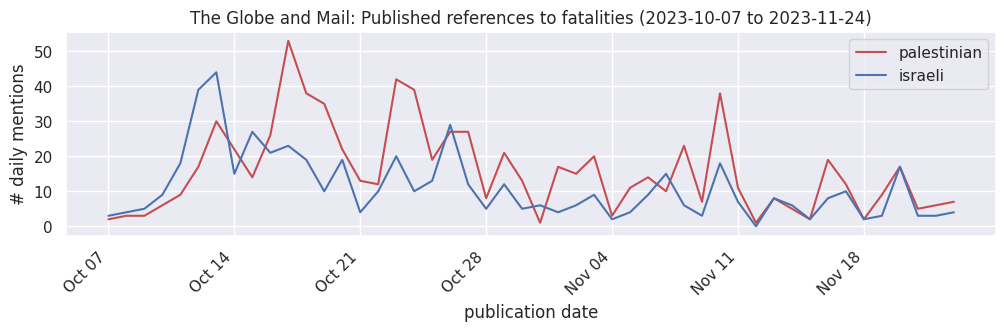

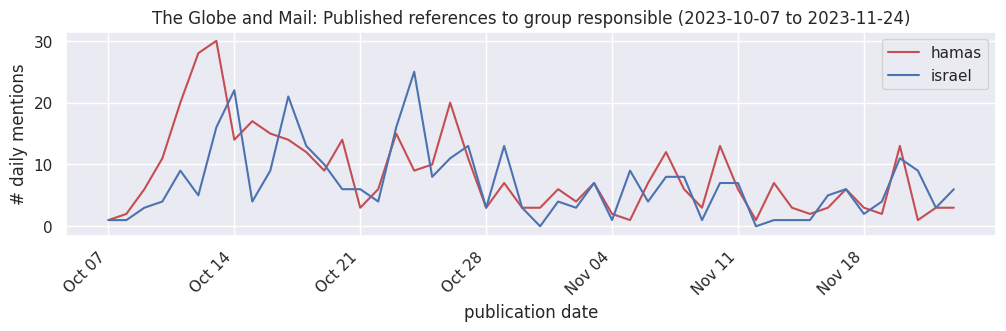

In [11]:
publication_name = 'The Globe and Mail'
pal_globe, isr_globe = count_death_mentions(globe, publication_name=publication_name, date_range=date_range)

fig, ax = plot_death_mentions(globe, publication_name=publication_name, date_range=date_range, palette=palette)
fig.savefig('figures/globe_death_mentions.png', dpi=800)

fig, ax = plot_blame_mentions(globe, publication_name=publication_name, date_range=date_range, palette=palette)
fig.savefig('figures/globe_blame_mentions.png', dpi=800)


The Toronto Star: 2023-10-07 to 2023-11-24 (456 articles)
----------------------------------------

594 mentions of Israeli deaths
874 mentions of Palestinian deaths

2.15 Israeli deaths per mention
17.18 Palestinian deaths per mention

479 mentions of Israeli responsibility
517 mentions of Hamas responsibility

2.47 Israeli deaths per mention of Hamas responsibility
31.34 Palestinian deaths per mention of Israel responsibility

87.04% of Israeli death mentions blamed on Hamas
54.81% of Palestinian death mentions blamed on Israel


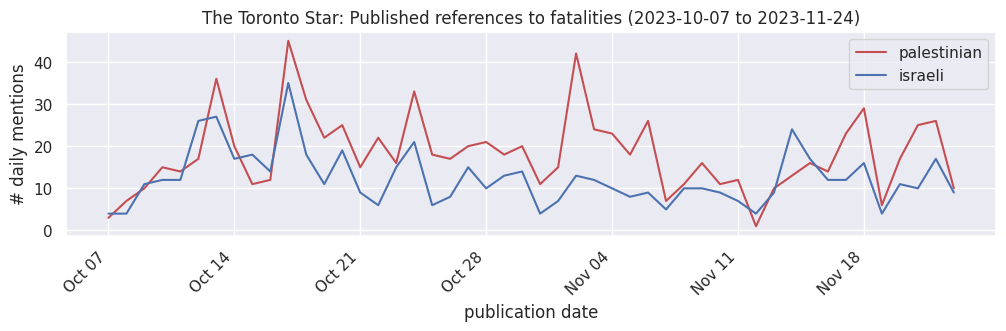

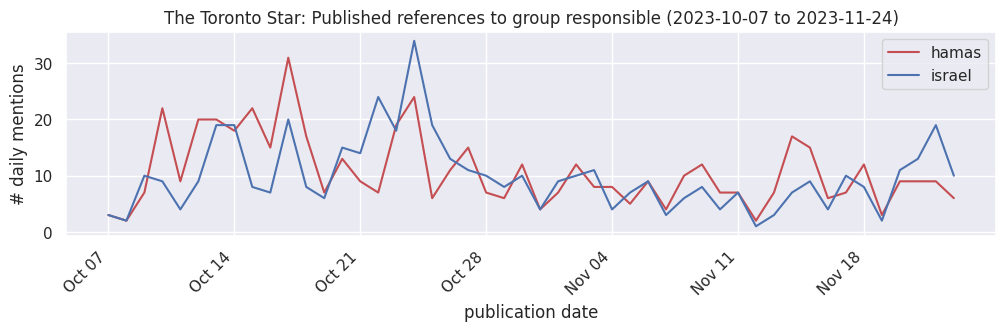

In [12]:
publication_name = 'The Toronto Star'
pal_star, isr_star = count_death_mentions(star, publication_name=publication_name, date_range=date_range)

fig, ax = plot_death_mentions(star, publication_name=publication_name, date_range=date_range, palette=palette)
fig.savefig('figures/star_death_mentions.png', dpi=800)

fig, ax = plot_blame_mentions(star, publication_name=publication_name, date_range=date_range, palette=palette)
fig.savefig('figures/star_blame_mentions.png', dpi=800)

The National Post: 2023-10-07 to 2023-11-24 (427 articles)
----------------------------------------

684 mentions of Israeli deaths
496 mentions of Palestinian deaths

1.87 Israeli deaths per mention
30.27 Palestinian deaths per mention

243 mentions of Israeli responsibility
507 mentions of Hamas responsibility

2.52 Israeli deaths per mention of Hamas responsibility
61.78 Palestinian deaths per mention of Israel responsibility

74.12% of Israeli death mentions blamed on Hamas
48.99% of Palestinian death mentions blamed on Israel


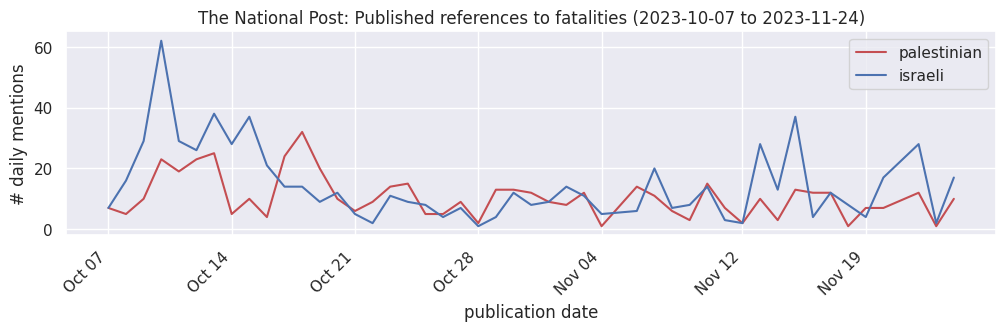

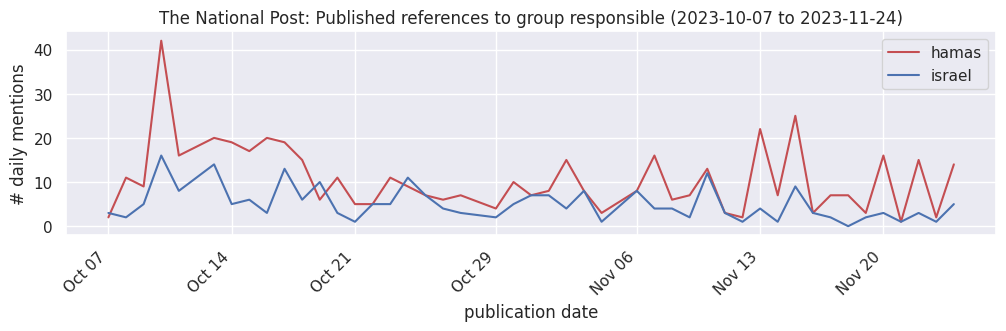

In [13]:
publication_name = 'The National Post'
pal_post, isr_post = count_death_mentions(post, publication_name=publication_name, date_range=date_range)

fig, ax = plot_death_mentions(post, publication_name=publication_name, date_range=date_range, palette=palette)
fig.savefig('figures/post_death_mentions.png', dpi=800)

fig, ax = plot_blame_mentions(post, publication_name=publication_name, date_range=date_range, palette=palette)
fig.savefig('figures/post_blame_mentions.png', dpi=800)


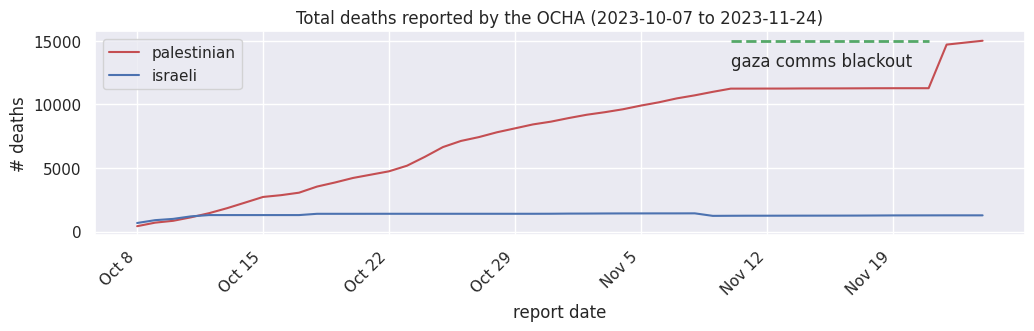

In [14]:
ocha_plot = ocha[['pal_total', 'isr_total']]
ocha_plot = ocha_plot.rename(columns={'pal_total': 'palestinian',
                                      'isr_total': 'israeli'})

fig, ax = plt.subplots(figsize=(12, 3))
sns.lineplot(ocha_plot, ax=ax, palette=palette, dashes=False)

ax.set_title(f'Total deaths reported by the OCHA ({date_range[0]} to {date_range[1]})')
ax.set_ylabel('# deaths')
ax.set_xlabel('report date')
ax.set_xticks(ocha_plot.index[::7])
ax.set_xticklabels(['Oct 8', 'Oct 15', 'Oct 22', 'Oct 29', 'Nov 5', 'Nov 12', 'Nov 19'])
fig.autofmt_xdate(rotation=45)

ax.hlines(15000, 33, 44, linestyles='--', colors='g', linewidth=2)
ax.text(33, 13050, 'gaza comms blackout')

plt.show()

fig.savefig('figures/ocha_deaths.png', dpi=800)